<a href="https://colab.research.google.com/github/fab0822/diabets/blob/master/signate_diabetes_ver4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import csv
import warnings
warnings.filterwarnings('ignore')

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import (roc_curve, auc)
from sklearn.model_selection import GridSearchCV


from google.colab import drive
from google.colab import files

In [133]:
SEED = 2021
NUM_COL = 8

In [134]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_logloss'}

In [135]:
grid_params = {
    'learning_rate': [0.0050, 0.0075, 0.001, 0.0015, 0.01, 0.05],
    'n_estimators': [40, 80, 120],
    'num_leaves': [8, 16, 32, 64, 128, 256],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [SEED], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.8],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

In [136]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
train = pd.read_csv('/content/drive/My Drive/train (1).csv')
test = pd.read_csv('/content/drive/My Drive/test (1).csv')

data = pd.concat([train, test]).reset_index(drop=True)

sub = pd.read_csv('/content/drive/My Drive/sample_submit (1).csv', header=None)

In [138]:
data.drop('index', axis=1, inplace=True)

In [139]:
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

In [140]:
D['Outcome'].count()

717

In [141]:
H['Outcome'].count()

2283

In [142]:
train.drop('index', axis=1, inplace=True)
test.drop('index', axis=1, inplace=True)

In [143]:
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,9,125,74,0,0,28.536910,0.444902,45,1
1,4,109,80,0,0,28.047673,0.238243,22,0
2,4,88,78,39,0,52.371341,0.279471,26,0
3,9,125,74,0,0,40.062688,0.203922,45,0
4,5,107,78,44,284,52.935068,0.284959,45,1


In [144]:
y_train = train['Outcome'].reset_index(drop=True)
train_features = train.drop(['Outcome'], axis=1)
test_features = test

In [145]:
train_features.loc[train_features['BMI']<1, 'BMI'] = 0
test_features.loc[test_features['BMI']<1, 'BMI'] = 0
data.loc[data['BMI']<1, 'BMI'] = 0

In [146]:
train_features[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = train_features[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
test_features[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = test_features[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [147]:
data['Insulin'].min()

15.0

In [148]:
data.isna().sum()

Pregnancies                    0
Glucose                        0
BloodPressure                186
SkinThickness               2920
Insulin                     4582
BMI                           51
DiabetesPedigreeFunction       0
Age                            0
Outcome                     2000
dtype: int64

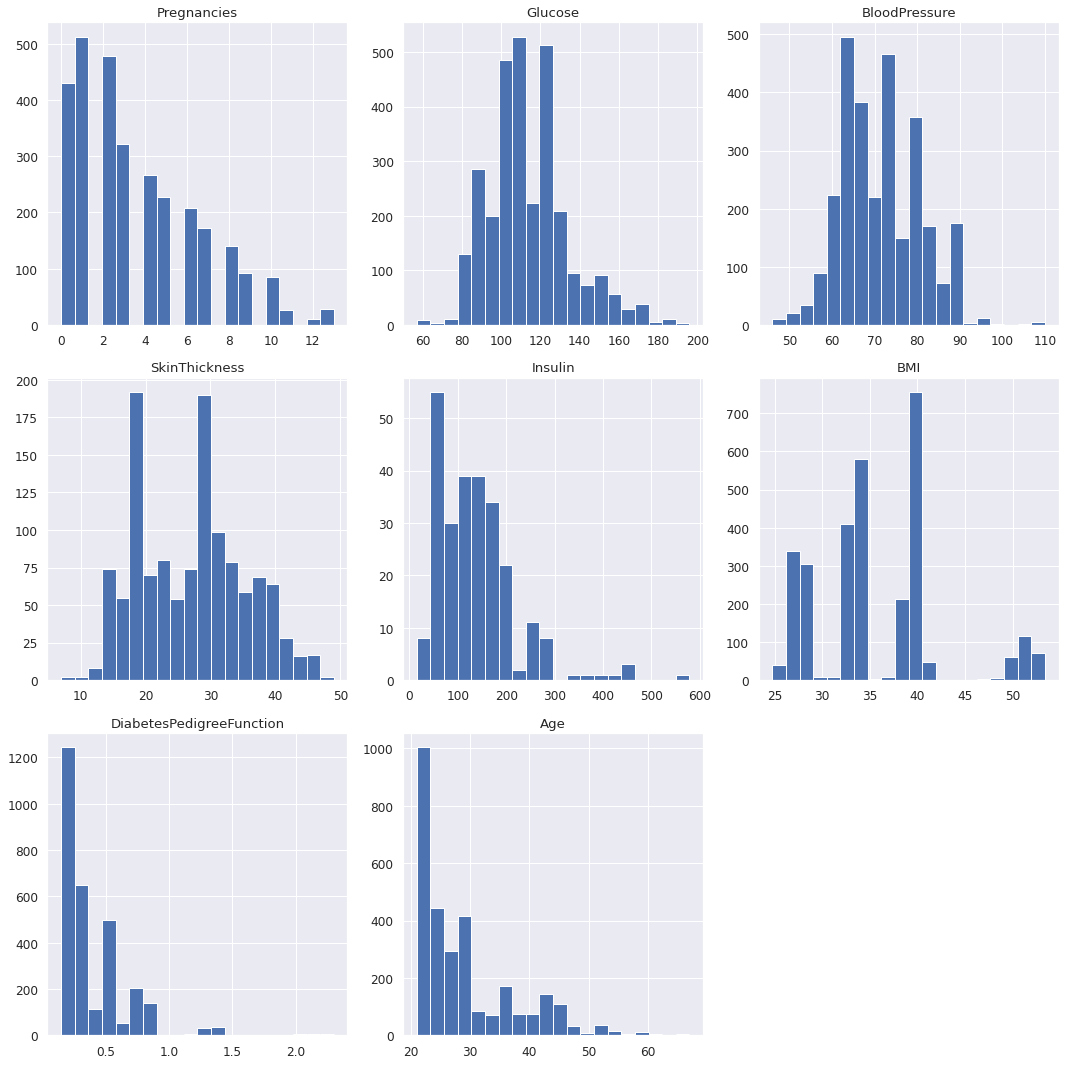

In [149]:
from pylab import rcParams

rcParams['figure.figsize'] = 15, 15
train_features.hist(bins=20)
plt.tight_layout()

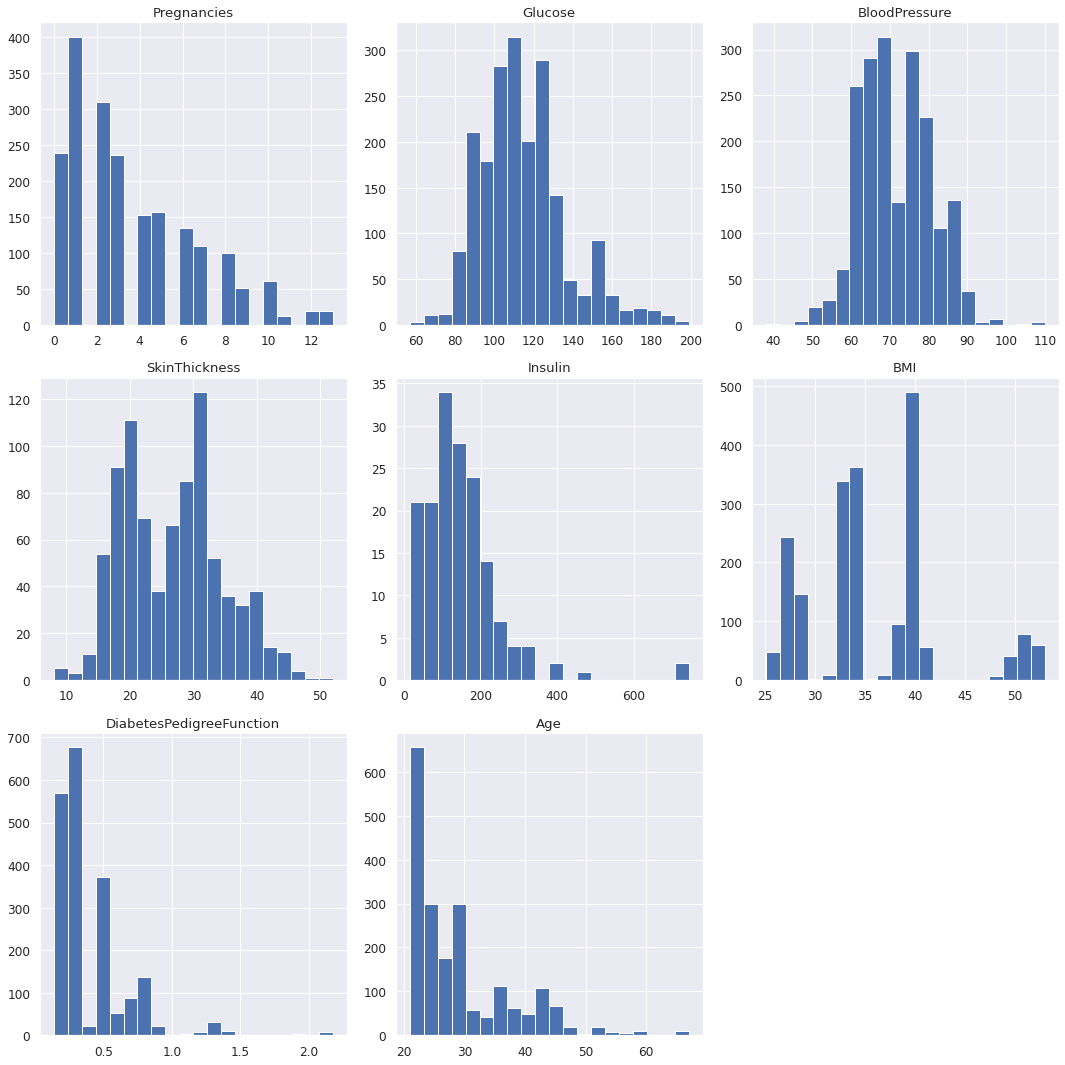

In [150]:
rcParams['figure.figsize'] = 15, 15
test_features.hist(bins=20)
plt.tight_layout()

In [151]:
#p01 = train_features.quantile(0.01)
#p99 = train_features.quantile(0.99)

#print(p01)
#print(p99)

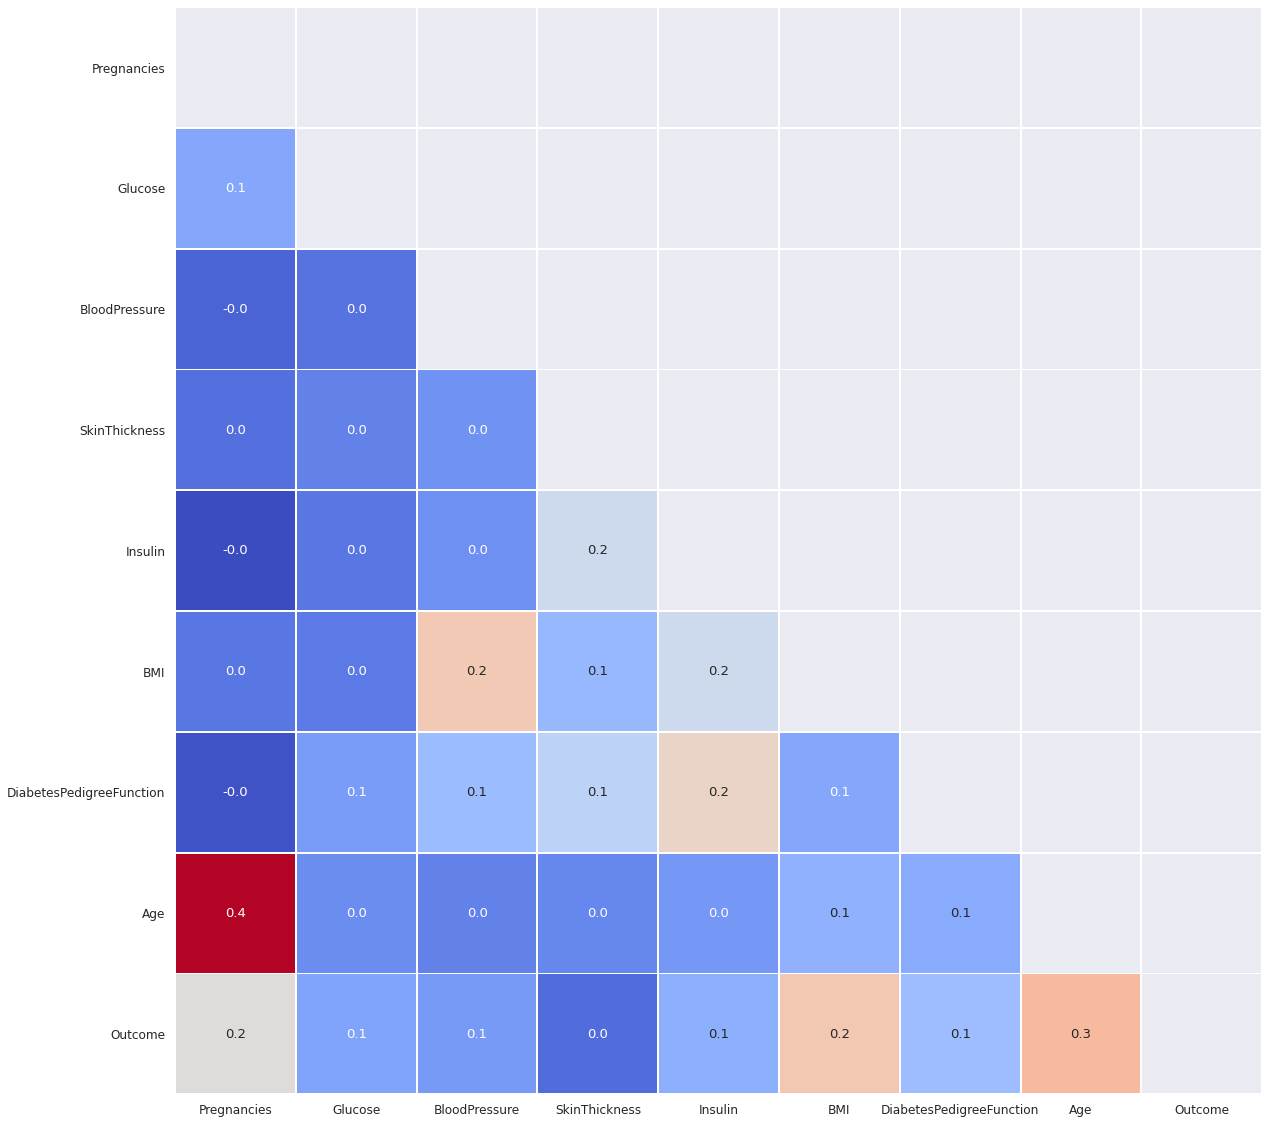

In [152]:
# Display numerical correlations (pearson) between features on heatmap.

sns.set(font_scale=1.1)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()

In [153]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

def mean_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].mean().reset_index()
    return temp

In [154]:
mean_target('Insulin')

,Outcome,Insulin
0,0.0,130.455621
1,1.0,148.770115


In [155]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isna()), 'Insulin'] = 130.45
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isna()), 'Insulin'] = 148.77
data.loc[(data['Outcome'].isna()) & (data['Insulin'].isna()), 'Insulin'] = (130.45+148.77) / 2

In [156]:
median_target('Glucose')

,Outcome,Glucose
0,0.0,111
1,1.0,115


In [157]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 111
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 115
data.loc[(data['Outcome'].isna()) & (data['Glucose'].isna()), 'Glucose'] = (111+115) / 2

In [158]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0.0,26.0
1,1.0,32.0


In [159]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 26
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32
data.loc[(data['Outcome'].isna()) & (data['SkinThickness'].isna()), 'SkinThickness'] = (26+32) / 2

In [160]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0.0,70.0
1,1.0,72.0


In [161]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 72
data.loc[(data['Outcome'].isna()) & (data['BloodPressure'].isna()), 'BloodPressure'] = (70+72) / 2

In [162]:
median_target('BMI')

,Outcome,BMI
0,0.0,33.619964
1,1.0,39.217924


In [163]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 33.62
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 39.22
data.loc[(data['Outcome'].isna()) & (data['BMI'].isnull()), 'BMI'] = (33.62+39.22) / 2

In [164]:
data.isna().sum()

Pregnancies                    0
Glucose                        0
BloodPressure                  0
SkinThickness                  0
Insulin                        0
BMI                            0
DiabetesPedigreeFunction       0
Age                            0
Outcome                     2000
dtype: int64

In [165]:
#features = pd.concat([train_features, test_features]).reset_index(drop=True)
data.drop('Outcome', axis=1, inplace=True)
features = data
print(features.shape)

(5000, 8)


In [166]:
features.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
4509,2,108,84.0,29.0,139.61,39.565032,0.269706,24
2672,9,125,62.0,32.0,148.77,34.004826,0.231843,28
2461,2,97,74.0,18.0,130.45,39.657317,0.212933,25
3415,1,123,64.0,21.0,139.61,27.954169,0.335927,21
2228,5,153,70.0,36.0,130.45,37.694177,0.527045,32


In [167]:
features.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3.567800,113.957600,71.381800,27.606000,136.961516,35.707396,0.400987,28.989400
std,3.040535,21.333505,9.056359,5.492904,27.177783,6.584771,0.271619,8.509722
min,0.000000,57.000000,38.000000,7.000000,15.000000,24.763302,0.137377,21.000000
25%,1.000000,100.000000,64.000000,26.000000,130.450000,32.637903,0.232290,22.000000
50%,3.000000,111.000000,70.000000,29.000000,139.610000,33.841397,0.269691,26.000000
75%,6.000000,125.000000,78.000000,30.000000,139.610000,39.627290,0.506604,33.000000
max,13.000000,199.000000,110.000000,52.000000,744.000000,53.400629,2.302072,67.000000


In [168]:
#X_train, X_valid, y_train, y_valid = train_test_split(features, y_train, test_size=0.2, random_state=SEED)

In [169]:
#model = lgb.LGBMClassifier(boosting_type= 'gbdt',
#          objective = 'binary',
#          n_jobs = 3, # Updated from 'nthread'
#          silent = True,
#          max_depth = params['max_depth'],
#          max_bin = params['max_bin'],
#          subsample_for_bin = params['subsample_for_bin'],
#          subsample = params['subsample'],
#          subsample_freq = params['subsample_freq'],
#          min_split_gain = params['min_split_gain'],
#          min_child_weight = params['min_child_weight'],
#          min_child_samples = params['min_child_samples'],
#          scale_pos_weight = params['scale_pos_weight'])
#
#grid = GridSearchCV(model, grid_params, cv=5, verbose=2)
#grid.fit(X_train, y_train)

In [170]:
#params['colsample_bytree'] = grid.best_params_['colsample_bytree']
#params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
#params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
#params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

In [171]:
#print(grid.best_params_)
#print(grid.best_estimator_)

In [172]:
#print(grid.score(X_valid, y_valid))

In [173]:
# Separating train and test set.

X_train = features.iloc[:len(y_train), :]
X_test = features.iloc[len(train):, :]

#X_train = pd.concat([X_train, X_valid]).reset_index(drop=True)
#y_train = pd.concat([y_train, y_valid]).reset_index(drop=True)
#X_test = test_features

In [174]:
X_test.shape

(2000, 8)

In [175]:
#cross validation
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_id, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
    X_tr = X_train.loc[train_index, :]
    X_valid = X_train.loc[val_index, :]
    y_tr = y_train[train_index]
    y_valid = y_train[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, )


    model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=100,
        num_boost_round=10000,
        early_stopping_rounds=10
    )

    oof_train[val_index] = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

Training until validation scores don't improve for 10 rounds.
[100]	training's binary_logloss: 0.0509487	valid_1's binary_logloss: 0.0524958
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0421586	valid_1's binary_logloss: 0.0422696
Training until validation scores don't improve for 10 rounds.
[100]	training's binary_logloss: 0.0509487	valid_1's binary_logloss: 0.0513258
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0421586	valid_1's binary_logloss: 0.0418127
Training until validation scores don't improve for 10 rounds.
[100]	training's binary_logloss: 0.0509487	valid_1's binary_logloss: 0.0545385
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0421586	valid_1's binary_logloss: 0.0470444
Training until validation scores don't improve for 10 rounds.
[100]	training's binary_logloss: 0.0509487	valid_1's binary_logloss: 0.0427709
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0421811	valid_1's binary

In [176]:
print(oof_train[:10])

scores = [
    m.best_score['valid_1']['binary_logloss'] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

[0.98861588 0.00284005 0.01678785 0.00665925 0.70504474 0.00284526
 0.94599981 0.98123588 0.00674642 0.00415309]
===CV scores===
[0.04226959365617721, 0.04181274347602618, 0.047044357105888654, 0.03625168635342339, 0.04340819003844027]
0.04215731412599114


In [177]:
y_pred_oof = (oof_train > 0.5).astype(int)
accuracy_score(y_train, y_pred_oof)

0.9883333333333333

In [182]:
y_sub = sum(y_preds) / len(y_preds)
y_sub = (y_sub > 0.5).astype(int)
y_sub[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [179]:
sub[1] = y_sub
sub.to_csv('submission_lgbm_ver4.3.csv', index=False, header=False)

sub.head()

,0,1
0,398,0
1,3833,0
2,4836,0
3,4572,0
4,636,0


In [180]:
files.download('submission_lgbm_ver4.3.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>